# 3D Deep Convolutional Generative Adversarial Network for Zeldovich Universe

In [1]:
# import matplotlib as mpl
# mpl.use('Agg')
import tensorflow as tf
print(tf.__version__)
import glob
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import matplotlib.pylab as plt
from IPython import display

from tensorflow.keras import backend as K
K.set_floatx('float32')
import h5py
# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

2.1.0


In [2]:
nGrid = 64
class zeldo_data:
    def load_data():

        z = 50
        hdf5_path = "../data/z" + str(z)+"_100.hdf5"
        hdf5_file = h5py.File(hdf5_path, mode='r')
        sim_z50 = hdf5_file["sims_z" + str(z)]
        
        z = 0
        hdf5_path = "../data/z" + str(z)+"_100.hdf5"
        hdf5_file = h5py.File(hdf5_path, mode='r')
        sim_z0 = hdf5_file["sims_z" + str(z)]
        train_test_split = 0.90
        split = np.int(train_test_split*sim_z0.shape[0])
        
        train_data = sim_z0[0:split, :, :, :].astype('float32')
        train_target = sim_z50[0:split, :, :, :].astype('float32')
        test_data = sim_z0[split:, :, :, :].astype('float32')
        test_target = sim_z50[split:, :, :, :].astype('float32')     
        return (train_data[:, :nGrid, :nGrid, :nGrid], train_target[:, :nGrid, :nGrid, :nGrid]), (test_data[:, :nGrid, :nGrid, :nGrid], test_target[:, :nGrid, :nGrid, :nGrid])
    
    
(train_images, _), (test_images, _) = zeldo_data.load_data()
print(train_images.shape)




# RESCALING IMAGES
tmin = train_images.min()
tmax = train_images.max()
print(tmin, tmax)
train_images = (train_images - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
test_images = (test_images - tmin) / (tmax - tmin)
print(train_images.min(), train_images.max())


(90, 64, 64, 64)
-1.0 73.00424
0.0 1.0


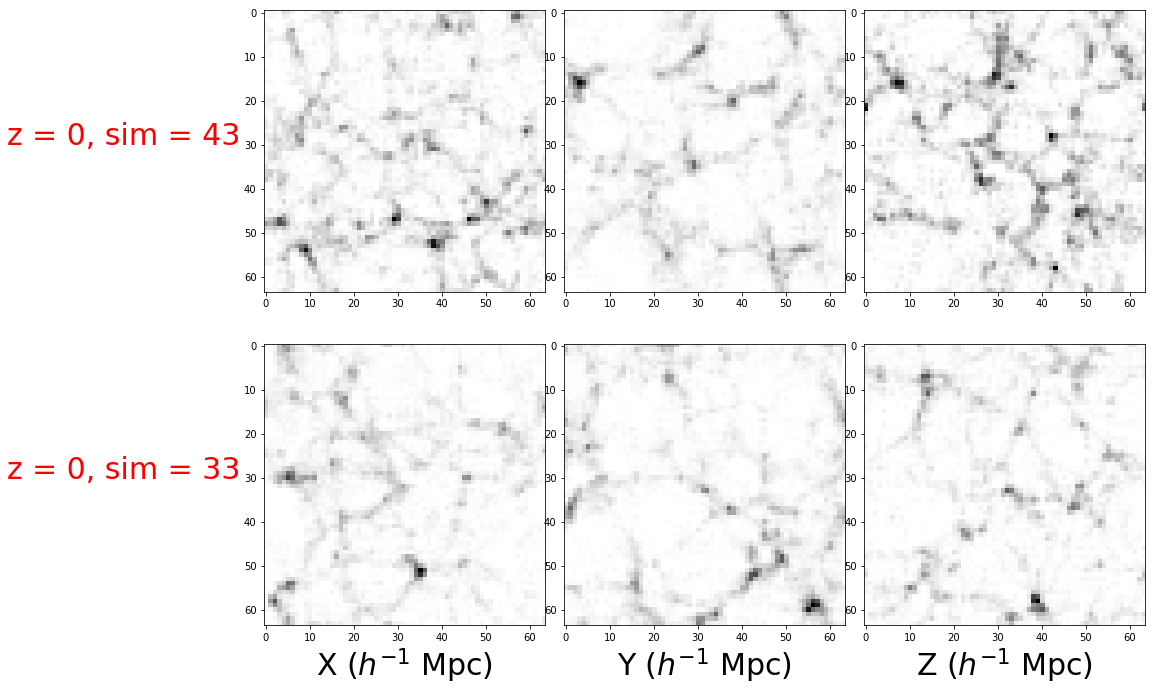

In [3]:
def rotateit(image, theta, isseg=False):
    order = 0 if isseg == True else 5
    return rotate(image, float(theta), reshape=False, order=order, mode='nearest')


ifPlotTrain = True

if ifPlotTrain:
    slice = 32
    simID = 43
    fig, ax = plt.subplots(2, 3, figsize = (16,  10))
    ax[0, 0].imshow(train_images[simID, slice, :, :], cmap='gray_r')
    ax[0, 1].imshow(train_images[simID, :, slice, :], cmap='gray_r')
    ax[0, 2].imshow(train_images[simID, :, :, slice], cmap='gray_r')

    ax[1, 0].imshow(train_images[simID-10, slice, :, :], cmap='gray_r')
    ax[1, 1].imshow(train_images[simID-10, :, slice, :], cmap='gray_r')
    ax[1, 2].imshow(train_images[simID-10, :, :, slice], cmap='gray_r')

    ax[1, 0].set_xlabel('X ($h^{-1}$ Mpc)',fontsize=30)
    ax[1, 1].set_xlabel('Y ($h^{-1}$ Mpc)', fontsize=30)
    ax[1, 2].set_xlabel('Z ($h^{-1}$ Mpc)', fontsize=30)

    ax[0, 0].set_ylabel('z = 0,' + ' sim = ' + str(simID), rotation=0, fontsize=30, labelpad=120, color = 'r')
    ax[1, 0].set_ylabel('z = 0,' + ' sim = ' + str(simID-10), rotation=0, fontsize=30, labelpad=120, color = 'r')


    plt.savefig('Plots/zeldo_snaps.png')
    plt.tight_layout()
    plt.show()

In [4]:
BUFFER_SIZE = 90
BATCH_SIZE = 2
lr_generator = 1e-5
lr_discriminator = 1e-5
EPOCHS = 128
noise_dim = 64
num_examples_to_generate = 1

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:

# ### The Generator
# 
# The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

def make_generator_model():
    model = tf.keras.Sequential()
    

    model.add(layers.Dense(4*4*4*2, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 4, 2)))
    assert model.output_shape == (None, 4, 4, 4, 2) # Note: None is the batch size

    model.add(tf.keras.layers.Conv3DTranspose(16, (7, 7, 7), strides=(4, 4, 4), padding='same', use_bias=False) )
    assert model.output_shape == (None, 16, 16, 16, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv3DTranspose(16, (7, 7, 7), strides=(2, 2, 2), padding='same', use_bias=False) )
    assert model.output_shape == (None, 32, 32, 32, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(tf.keras.layers.Conv3DTranspose(1, (3, 3, 3), strides=(2, 2, 2), padding='same', use_bias=False, activation='tanh') )
    assert model.output_shape == (None, 64, 64, 64, 1)

    return model

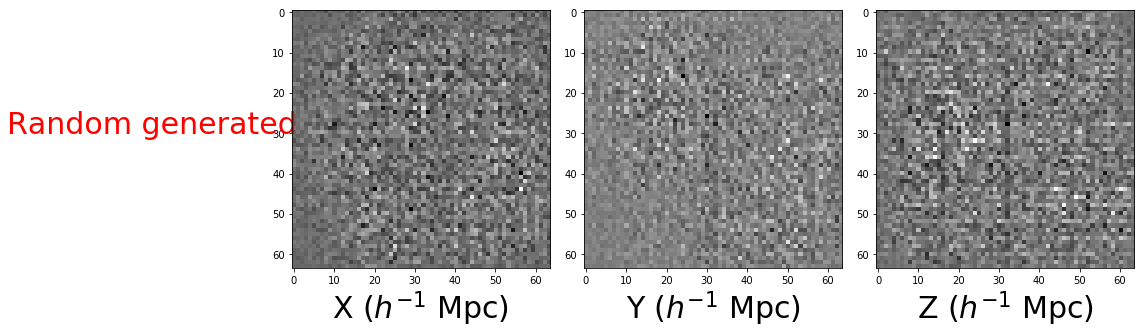

-2.7171657 2.7190244
-0.015225744 0.016236719


In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

ifPlotRandom = True

if ifPlotRandom:
    slice = 32
    simID = 43
    fig, ax = plt.subplots(1, 3, figsize = (16,  5))
    ax[0].imshow(generated_image[0, slice, :, :, 0], cmap='gray_r')
    ax[1].imshow(generated_image[0, :, slice, :, 0], cmap='gray_r')
    ax[2].imshow(generated_image[0, :, :, slice, 0], cmap='gray_r')



    ax[0].set_xlabel('X ($h^{-1}$ Mpc)',fontsize=30)
    ax[1].set_xlabel('Y ($h^{-1}$ Mpc)', fontsize=30)
    ax[2].set_xlabel('Z ($h^{-1}$ Mpc)', fontsize=30)

    ax[0].set_ylabel('Random generated', rotation=0, fontsize=30, labelpad=120, color = 'r')
    plt.tight_layout()
#     plt.clf()
    plt.show()



print(np.min(noise), np.max(noise))
print(np.min(generated_image), np.max(generated_image))


In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv3D(32, (7, 7, 7), strides=(2, 2, 2), padding='same', input_shape=(64, 64, 64, 1)) )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv3D(16, (5, 5, 5), strides=(1, 1, 1), padding='same') )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [9]:
# Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print ('d-fake: ', decision)

test_image = test_images[2, :, :, :]
test_image = np.expand_dims(test_image, 4)
test_image = np.expand_dims(test_image, 0)
decision = discriminator(test_image)
print ('d-real: ', decision)


d-fake:  tf.Tensor([[-0.00077935]], shape=(1, 1), dtype=float32)
d-real:  tf.Tensor([[-0.00271586]], shape=(1, 1), dtype=float32)


/Users/nramachandra/anaconda3/envs/env_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [10]:
# ## Define the loss and optimizers
# Define loss functions and optimizers for both models.
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# ### Discriminator loss
# This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# ### Generator loss
# The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [11]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(lr_generator)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_discriminator)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
# ## Define the training loop
# We will reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
    
#       print(images.shape, generated_images.shape)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss



def train(dataset, epochs):

  gen_loss_arr = [] 
  disc_loss_arr = []

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      image_batch = np.expand_dims(image_batch, 4)
      gen_loss, disc_loss = train_step(image_batch)
      

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 4 epochs
    # Save the 4 models
    if (epoch + 1) % np.int(EPOCHS/4) == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start), gen_loss, disc_loss)
    
    disc_loss_arr = np.append(disc_loss_arr, disc_loss)
    gen_loss_arr = np.append(gen_loss_arr, gen_loss)
  
  return gen_loss_arr, disc_loss_arr

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


# **Generate and save images**
# 

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
#       plt.subplot(4, 4, i+1) # for 16 images
      plt.subplot(1, 1, i+1) # for 1 image
      plt.imshow(predictions[i, :, :, slice, 0] * (tmax - tmin) + tmin, cmap='gray_r')
      plt.axis('off')
      plt.tight_layout()

  plt.savefig('Plots/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

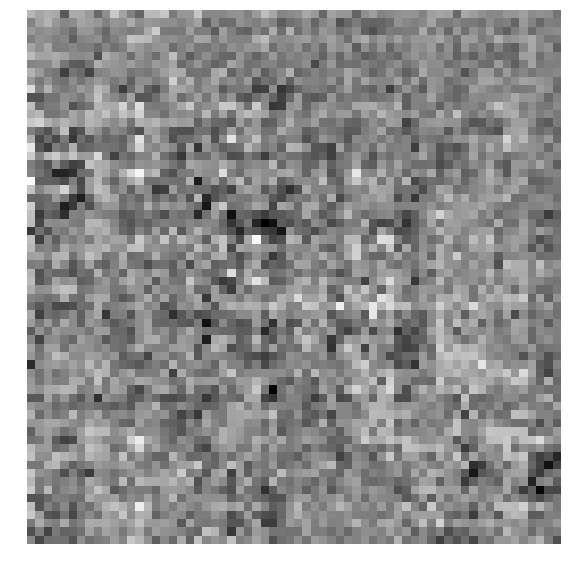

Time for epoch 128 is 80.99407529830933 sec tf.Tensor(1.0019022, shape=(), dtype=float32) tf.Tensor(1.1249188, shape=(), dtype=float32)
training ends


In [14]:
# ## Train the model
# Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).
# 
# At the beginning of the training, the generated images look like random noise. As training progresses, the generated structure should look increasingly real. 
print('training beings')
gen_loss_arr, disc_loss_arr = train(train_dataset, EPOCHS)
print('training ends')

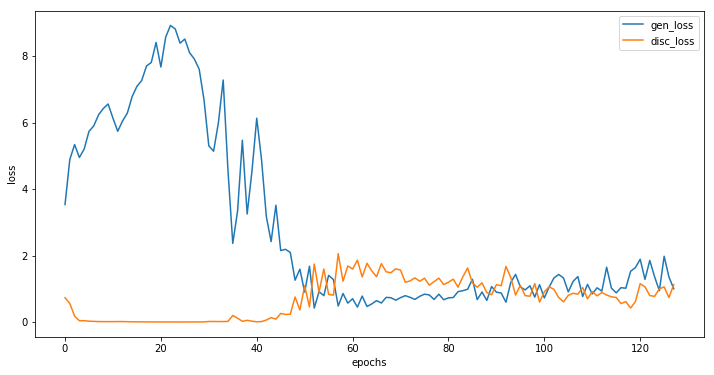

loss shape (128,)


In [15]:
plt.figure(2732, figsize = (12, 6))
plt.plot(gen_loss_arr, label='gen_loss')
plt.plot(disc_loss_arr, label ='disc_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('Plots/loss.png')
plt.show()
print('loss shape', np.shape(gen_loss_arr))
# Restore the latest checkpoint.

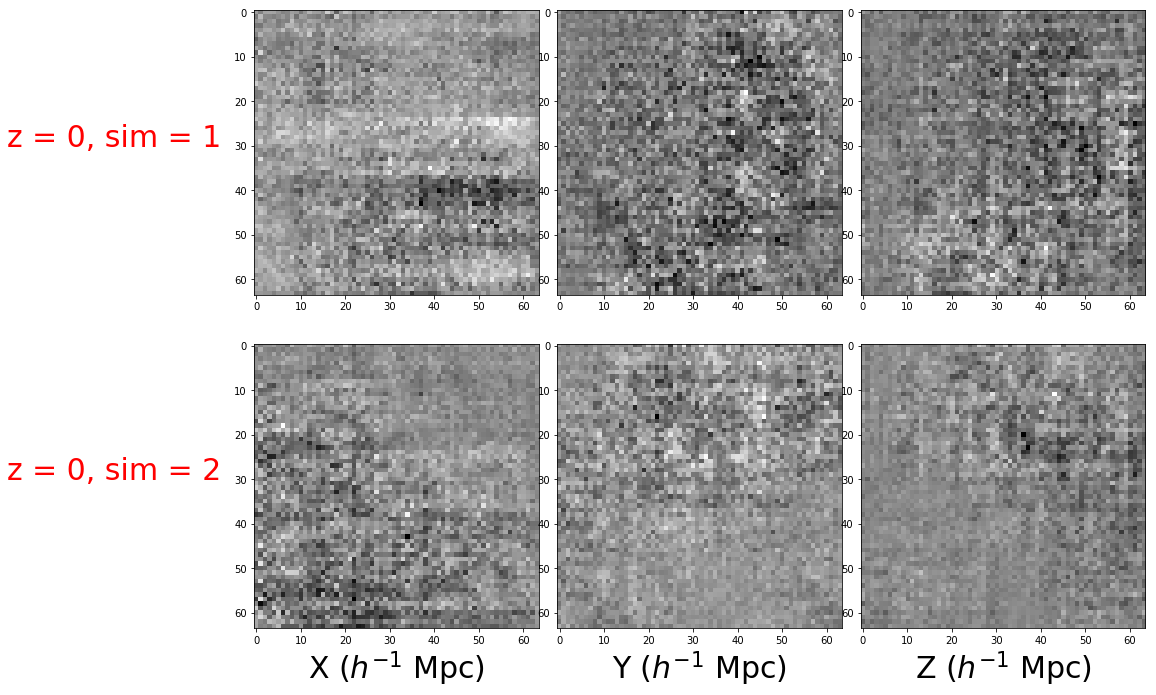

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

def generate_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))
  print(predictions.shape[0])

#   for i in range(predictions.shape[0]):
#   plt.subplot(1, 1, )
  plt.imshow(predictions[0, :, slice, :, 0] * (tmax - tmin) + tmin, cmap='gray_r')
#   plt.axis('off')
  plt.tight_layout()

  plt.savefig('Plots/image_at_epoch_{:04d}.png'.format(epoch))
#   plt.clf()
  plt.show()


ifPlotGen = True

if ifPlotTrain:
    
    test_input = tf.random.normal([1, noise_dim])
    new_gen = generator(test_input, training=False)* (tmax - tmin) + tmin
    test_input2 = tf.random.normal([1, noise_dim])
    new_gen2 = generator(test_input2, training=False)* (tmax - tmin) + tmin
    
    slice = 32
    fig, ax = plt.subplots(2, 3, figsize = (16,  10))
    ax[0, 0].imshow(new_gen[0, slice, :, :, 0], cmap='gray_r')
    ax[0, 1].imshow(new_gen[0, :, slice, :, 0], cmap='gray_r')
    ax[0, 2].imshow(new_gen[0, :, :, slice, 0], cmap='gray_r')

    ax[1, 0].imshow(new_gen2[0, slice, :, :, 0], cmap='gray_r')
    ax[1, 1].imshow(new_gen2[0, :, slice, :, 0], cmap='gray_r')
    ax[1, 2].imshow(new_gen2[0, :, :, slice, 0], cmap='gray_r')

    ax[1, 0].set_xlabel('X ($h^{-1}$ Mpc)',fontsize=30)
    ax[1, 1].set_xlabel('Y ($h^{-1}$ Mpc)', fontsize=30)
    ax[1, 2].set_xlabel('Z ($h^{-1}$ Mpc)', fontsize=30)

    ax[0, 0].set_ylabel('z = 0,' + ' sim = 1' , rotation=0, fontsize=30, labelpad=120, color = 'r')
    ax[1, 0].set_ylabel('z = 0,' + ' sim = 2' , rotation=0, fontsize=30, labelpad=120, color = 'r')


    plt.savefig('Plots/zeldo_snaps.png')
    plt.tight_layout()
    plt.show()
